Required libraries

In [25]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re
import random
from PIL import Image

Read images and masks

In [68]:
def sort_key(s):
    # Extract numeric part from the string
    numeric_part = re.findall(r'\d+', s)
    
    # If numeric part is found, return it as integer, else print the filename and return 0
    if numeric_part:
        return int(numeric_part[0])
    else:
        print(f"No numeric part in filename: {s}")
        return 0

# Sort filenames before loading
image_dir = "images/images"
mask_dir = "black_mark_masks/black_mark_region"


# Ensure directories exist
if not os.path.exists(image_dir):
    print(f"Image directory does not exist: {image_dir}")
    exit(1)

if not os.path.exists(mask_dir):
    print(f"Mask directory does not exist: {mask_dir}")
    exit(1)

# Get sorted lists of image and label filenames
image_filenames = sorted(os.listdir(image_dir), key=sort_key)
mask_filenames = sorted(os.listdir(mask_dir), key=sort_key)

# Verify that there is a 1-to-1 correspondence between images and labels
if len(image_filenames) != len(mask_filenames):
    print("Number of image files does not match number of mask files.")
    exit(1)

for image_file, mask_file in zip(image_filenames, mask_filenames):
    image_basename, _ = os.path.splitext(image_file)
    mask_basename, _ = os.path.splitext(mask_file)

    if image_basename != mask_basename:
        print(f"Mismatch: image file {image_file} does not match mask file {mask_file}")
        exit(1)

# Load images and masks in the sorted order
mask_images_3channels = []
mask_images_1channel = []
RGB_images = []

for image_file, label_file in zip(image_filenames, mask_filenames):
    # Load image
    imgpath = os.path.join(image_dir, image_file)
    img = cv2.imread(imgpath)
    rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    RGB_images.append(rgb_image)
    
    # Load mask
    maskpath = os.path.join(mask_dir, label_file)
    mask = cv2.imread(maskpath, cv2.IMREAD_GRAYSCALE)
    mask_3channel = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    mask_images_3channels.append(mask_3channel)
    mask_images_1channel.append(mask)

print("Loaded all images and labels in matching order.")

Loaded all images and labels in matching order.


In [69]:
print(f"Processed {len(RGB_images)} images")

Processed 406 images


Check if masks correctly overlapped with correspondant images

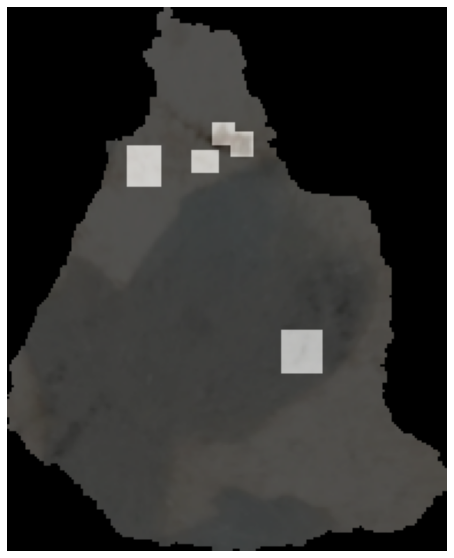

In [99]:
# Generate a random index
index = random.choice(range(len(RGB_images)))

# Add weighted images to create a single image with bounding boxes
dst = cv2.addWeighted(RGB_images[index], 0.5, mask_images_3channels[index], 0.5, 0)

# Plot the image
plt.figure(figsize=(10,10))
plt.imshow(dst)
plt.axis('off')
plt.show()

Create and Save eroded masks

In [28]:
# Create a new directory for eroded masks
os.makedirs('Eroded_masks_original_size', exist_ok=True)

# Initialize an empty list for eroded masks
eroded_masks = []

# Define the kernel for erosion operation
kernel = np.ones((11, 11), np.uint8)

# Loop over masks
for i in range(len(mask_images_1channel)):
    # Apply mask on image (this assumes mask and image are the same size)
    mask = mask_images_1channel[i] * (RGB_images[i][:,:,0] > 0)
    #mask = mask_images_1channel[i]
    # Erode the mask
    eroded_mask = cv2.erode(mask, kernel)
    
    # Add the eroded mask to the list
    eroded_masks.append(mask)

    # Save the eroded mask to file
    cv2.imwrite(f'Eroded_masks_original_size/eroded_mask_{i}.png', eroded_mask)

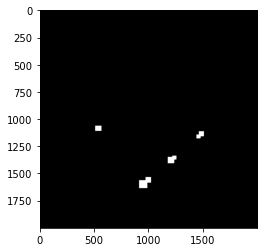

In [20]:
plt.imshow(eroded_masks[3], cmap = 'gray')

Prepare images for first iteration of inpainting

In [23]:
def make_background_white(image, lower_threshold, upper_threshold):
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, foreground_mask = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY)
    background_mask = cv2.bitwise_not(foreground_mask)
    image_with_white_background = image.copy()
    image_with_white_background[np.where(background_mask == 255)] = [255, 255, 255]

    white_background_image = Image.fromarray(image_with_white_background)

    return white_background_image

def make_background_black(image, edge_threshold=100):

    if isinstance(image, str):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    edges = cv2.Canny(gray_image, edge_threshold, edge_threshold * 3)
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.zeros_like(gray_image)

    # Fill the largest contour (assumed to be the background) with white
    largest_contour = max(contours, key=cv2.contourArea)
    cv2.drawContours(mask, [largest_contour], 0, 255, -1)

    image_with_black_background = image.copy()
    image_with_black_background[mask == 0] = [0, 0, 0]
    
    image_with_black_background = cv2.cvtColor(image_with_black_background, cv2.COLOR_RGB2BGR)
    black_background_image = Image.fromarray(image_with_black_background)

    return black_background_image

def keep_white_pixels(image, lower_threshold=(200, 200, 200), upper_threshold=(255, 255, 255)):
    
    if isinstance(image, str):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    mask = cv2.inRange(image, lower_threshold, upper_threshold)

    black_image = np.zeros_like(image)
    black_image[mask == 255] = image[mask == 255]
    gray_image = cv2.cvtColor(black_image, cv2.COLOR_RGB2GRAY)
    white_pixels_image = Image.fromarray(gray_image)

    return white_pixels_image

In [26]:
# Create a new directory for first iteration inpainting
os.makedirs('Inpainted_Results/Original/First_iter_images', exist_ok=True)

# Iterate over each image in RGB_images
for i, img in enumerate(RGB_images):
    # Apply the function
    white_background_image = make_background_white(img, 50, 255)

    # Save the image to file
    white_background_image.save(f'Inpainted_Results/Original/First_iter_images/image_W_{i}.png')

Prepare images for 2nd inpainting iteration

In [29]:
os.makedirs('Inpainted_Results/Original/Second_iter_masks', exist_ok=True)

def sort_key(s):
    return int(re.findall(r'\d+', s)[0])

# Specify the directory of the images
directory = "Inpainted_Results/Original/First_iter_results"

# Get list of all files in the specified directory and sort them
files = os.listdir(directory)
files = sorted(files, key=sort_key)

# Full paths to files
full_paths = [os.path.join(directory, file) for file in files]

# Iterate over each file in the directory
for i, file in enumerate(full_paths):
    # Apply the functions
    black_background_image = make_background_black(file)
    white_pixels_image = keep_white_pixels(np.array(black_background_image))

    # Save the image to file
    white_pixels_image.save(f'Inpainted_Results/Original/Second_iter_masks/mask_image_{i}.png')

The final result (Making the background black again)

In [ ]:
def make_background_black_updated(image, edge_threshold=100, frame_size=10):

    if isinstance(image, str):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Add frame around the image
    height, width, _ = image.shape
    framed_image = cv2.copyMakeBorder(image, frame_size, frame_size, frame_size, frame_size, cv2.BORDER_CONSTANT, value=[255, 255, 255])

    gray_image = cv2.cvtColor(framed_image, cv2.COLOR_RGB2GRAY)

    edges = cv2.Canny(gray_image, edge_threshold, edge_threshold * 3)
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.zeros_like(gray_image)

    # Fill the largest contour (assumed to be the background) with white
    largest_contour = max(contours, key=cv2.contourArea)
    cv2.drawContours(mask, [largest_contour], 0, 255, -1)

    framed_image_with_black_background = framed_image.copy()
    framed_image_with_black_background[mask == 0] = [0, 0, 0]

    # Remove the frame
    image_with_black_background = framed_image_with_black_background[frame_size:-frame_size, frame_size:-frame_size]
    
    image_with_black_background = cv2.cvtColor(image_with_black_background, cv2.COLOR_RGB2BGR)
    black_background_image = Image.fromarray(image_with_black_background)

    return black_background_image

In [32]:
def make_background_black_updated_3(image, edge_threshold=100, frame_size=10, min_contour_area=500):

    if isinstance(image, str):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Add frame around the image
    height, width, _ = image.shape
    framed_image = cv2.copyMakeBorder(image, frame_size, frame_size, frame_size, frame_size, cv2.BORDER_CONSTANT, value=[255, 255, 255])

    gray_image = cv2.cvtColor(framed_image, cv2.COLOR_RGB2GRAY)

    edges = cv2.Canny(gray_image, edge_threshold, edge_threshold * 3)
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.zeros_like(gray_image)

    # Fill the contours with white, but only if they are large enough
    for contour in contours:
        if cv2.contourArea(contour) > min_contour_area:
            cv2.drawContours(mask, [contour], 0, 255, -1)

    framed_image_with_black_background = framed_image.copy()
    # Apply the mask to the color image
    for i in range(3):  # For each color channel
        framed_image_with_black_background[:, :, i][mask == 0] = 0

    # Remove the frame
    image_with_black_background = framed_image_with_black_background[frame_size:-frame_size, frame_size:-frame_size]

    return image_with_black_background


In [33]:
os.makedirs('Inpainted_Results/Original/Final_results', exist_ok=True)

def sort_key(s):
    return int(re.findall(r'\d+', s)[0])

# Specify the directory of the images
directory = "Inpainted_Results/Original/Second_iter_results"

# Get list of all files in the specified directory and sort them
files = os.listdir(directory)
files = sorted(files, key=sort_key)

# Full paths to files
full_paths = [os.path.join(directory, file) for file in files]

# Iterate over each file in the directory
for i, file in enumerate(full_paths):
    # Apply the functions
    black_background_image = make_background_black_updated_3(file)
    
    black_background_image = Image.fromarray(black_background_image)

    # Save the image to file
    black_background_image.save(f'Inpainted_Results/Original/Final_results/inpainted_image_{i}.png')